# Q1

In [1]:
import numpy as np
import pandas as pd
import time

## A)

### Importing Data

In [2]:
house_data = pd.read_csv("./data/house_prices.csv")

In [3]:
x, y = house_data.drop(["price"], axis=1) ,house_data["price"]

In [4]:
x.shape, y.shape

((545, 8), (545,))

In [5]:
x.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,parking
0,7420,4,2,3,1,0,0,2
1,8960,4,4,4,1,0,0,3
2,9960,3,2,2,1,0,1,2
3,7500,4,2,2,1,0,1,3
4,7420,4,1,2,1,1,1,2


In [6]:
print("min info:")
print(x.min())
print('-' * 20)
print("max info:")
print(x.max())

min info:
area         1650
bedrooms        1
bathrooms       1
stories         1
mainroad        0
guestroom       0
basement        0
parking         0
dtype: int64
--------------------
max info:
area         16200
bedrooms         6
bathrooms        4
stories          4
mainroad         1
guestroom        1
basement         1
parking          3
dtype: int64


In [7]:
y.head()

0    791000
1    919000
2    994000
3    811000
4    801000
Name: price, dtype: int64

### Normalization

In [8]:
def normalize(x, base=None):
    if base:
        mean = base[0]
        std = base[1]
        return (x - mean) / std
    
    mean = x.mean(axis=0)
    std_dev = x.std(axis=0)
    
    # handling dev by zero:
    std_dev[std_dev == 0] = 1
    
    normalized_x = (x - mean) / std_dev
    return normalized_x, mean, std_dev

In [9]:
x_norm, mean, std_dev = normalize(x)

In [10]:
print("min info:")
print(x.min())
print('-' * 20)
print("max info:")
print(x.max())

min info:
area         1650
bedrooms        1
bathrooms       1
stories         1
mainroad        0
guestroom       0
basement        0
parking         0
dtype: int64
--------------------
max info:
area         16200
bedrooms         6
bathrooms        4
stories          4
mainroad         1
guestroom        1
basement         1
parking          3
dtype: int64


## B)

### Batch GD

In [11]:
def predict(x, w):
    return x.dot(w)

def mse(y_pred, y):
    e = y_pred - y
    return 0.5 * np.mean(e * e)

def initial_weights(n):
    return np.zeros(n)

def compute_gradient(x, y, y_pred):
    m = len(y)
    e = y_pred - y
    
    gradient_w = (1/m) * x.T.dot(e)
    
    return gradient_w

In [12]:
# adding bias term to features
m = len(y)
xb = np.hstack([x_norm, np.ones((m, 1))])
n_features = xb.shape[1]
print("number of features: ", n_features)

number of features:  9


In [13]:
initial_w = initial_weights(n_features)

### settings

In [14]:
n_epochs = 80
batch_epochs = n_epochs
lr = 0.08

In [15]:
def gradient_descent(x, y, initial_w, max_iter, lr):
    losses = []
    w = initial_w
    for iteration in range(max_iter):
        prediction = predict(x, w)
        loss = mse(prediction, y)
        gradient = compute_gradient(x, y, prediction)
        w -= lr * gradient
        losses.append(loss)
        
    return w, losses

In [16]:
from matplotlib import pyplot as plt

tic = time.time()
w, losses = gradient_descent(xb, y, initial_w, n_epochs, lr)
tok = time.time()

batch_time = tok - tic

w_batch = w
print(f"batch training time: {batch_time}s")
print("last iteration loss: ", losses[-1])

batch training time: 0.01468801498413086s
last iteration loss:  18905658.352065586


In [17]:
print("weights: ", w)

weights:  [155987.96593602   1850.8641151    1486.06146937   5738.41833977
   5357.15693232   2628.74644699  11394.43664686   7992.68545453
 607038.63741661]


### Plotting

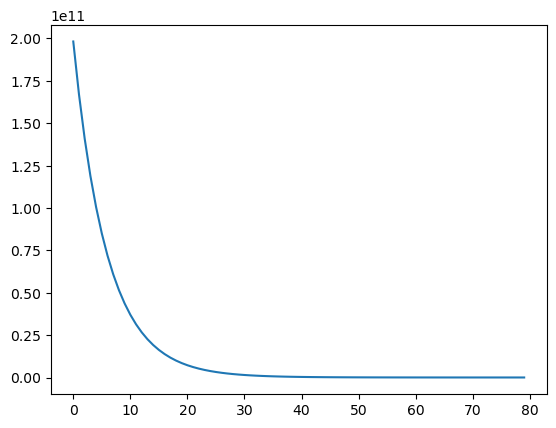

In [18]:
fig, ax = plt.subplots()
ax.plot(losses)

## C)

### Predict

In [19]:
sample = np.array([7700, 3, 2, 1, 1, 0, 0, 2])
sample_n = normalize(sample, [mean, std_dev])

# adding bias term:
sample_norm = np.hstack([sample_n, 1])

prediction = predict(sample_norm, w)
print("prediction: ", prediction)

prediction:  791867.9076636164


According to the prediction of the model on training data their price is high

## D)

### Mini-Batch GD

In [20]:
def batch_iter(y, x, batch_size, num_batches=1, shuffle=True):
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_x = x[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_x = x
        
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_x[start_index:end_index], shuffled_y[start_index:end_index]

In [21]:
def mini_batch_gd(x, y, initial_w, batch_size, max_iter, lr):
    losses = []
    w = initial_w
    for iteration in range(max_iter):
        for k in range(0, len(y)//batch_size):
            for x_batch, y_batch in batch_iter(y, x, batch_size=batch_size, num_batches=1):
                prediction = predict(x_batch, w)
                gradient = compute_gradient(x_batch, y_batch, prediction)
                w -= lr * gradient

                pred = predict(x, w)
                loss = mse(pred, y)
                losses.append(loss)
        
    return w, losses

### settings

In [22]:
epochs = 40
mb_epochs = epochs

lr = 0.01
batch_size = 32

initial_w = initial_weights(n_features)
print(initial_w)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
tic = time.time()
w_mb, losses_mb = mini_batch_gd(xb, y, initial_w, batch_size, epochs, lr)
tok = time.time()

mb_time = tok - tic
print("mini batch time in seconds: ", mb_time)

mini batch time in seconds:  0.32747483253479004


In [24]:
print("weights: ", w_mb)

weights:  [156165.79420395   1304.61193446   1353.07123378   6397.69952434
   4932.89982467   2421.56857338  11839.59357696   8006.65425433
 607163.67077934]


In [25]:
sample = np.array([7700, 3, 2, 1, 1, 0, 0, 2])
sample_n = normalize(sample, [mean, std_dev])

# adding bias term:
sample_norm = np.hstack([sample_n, 1])

predict(sample_norm, w_mb)

790993.8445070323

### Plotting

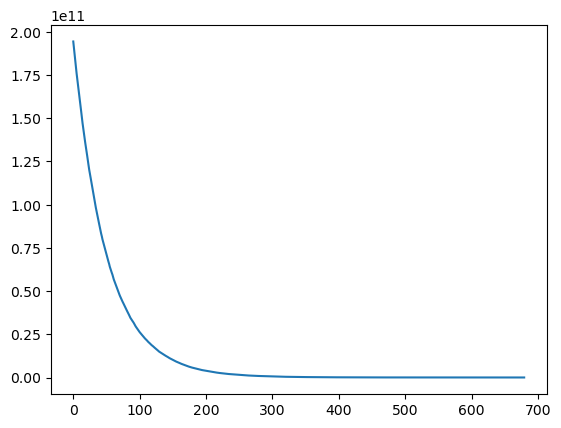

In [26]:
fig, ax = plt.subplots()
ax.plot(losses_mb)

### Stochastic Gradient Descent

In [27]:
def stochastid_gradient_descent(x, y, initial_w, max_iter, lr):
    losses = []
    w = initial_w
    for iteration in range(max_iter):
        for k in range(0, len(y)):
            for x_batch, y_batch in batch_iter(y, x, batch_size=1, num_batches=1):
                prediction = predict(x_batch, w)
                gradient = compute_gradient(x_batch, y_batch, prediction)
                w -= lr * gradient
                pred = predict(x, w)
                loss = mse(pred, y)
                losses.append(loss)

    return w, losses

### settings

In [28]:
epochs = 10
sgd_epochs = epochs
lr = 0.001

initial_w = initial_weights(n_features)
print(initial_w)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [29]:
tic = time.time()
w_sgd, losses_sgd = stochastid_gradient_descent(xb, y, initial_w, epochs, lr)
tok = time.time()

sgd_time = tok - tic
print("stoch gd time in seconds: ", sgd_time)

stoch gd time in seconds:  2.5670859813690186


In [30]:
print("weights: ", w_sgd)

weights:  [155010.87364677   3049.98678042   2796.13815854   3882.7895401
   6913.0843103    2505.63925191  11026.97503733   7847.42355389
 605411.59530947]


In [31]:
sample = np.array([7700, 3, 2, 1, 1, 0, 0, 2])
sample_n = normalize(sample, [mean, std_dev])

# adding bias term:
sample_norm = np.hstack([sample_n, 1])

predict(sample_norm, w_sgd)

793470.8115459161

### Plotting

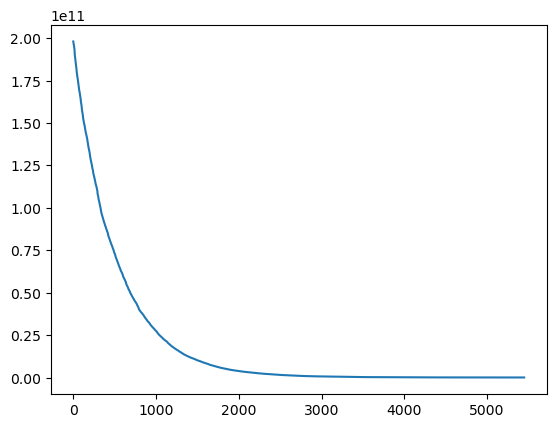

In [32]:
fig, ax = plt.subplots()
ax.plot(losses_sgd)

## Comparisons

In [33]:
print(f"batch epochs: {batch_epochs}, batch time: {batch_time}")
print(f"sgd epochs: {sgd_epochs}, sgd time: {sgd_time}")
print(f"mini-batch epochs: {mb_epochs}, mini-batch time: {mb_time}")

batch epochs: 80, batch time: 0.01468801498413086
sgd epochs: 10, sgd time: 2.5670859813690186
mini-batch epochs: 40, mini-batch time: 0.32747483253479004


as we expected the time in batch is less than mini batch and minibatch is less than sgd.<br>
but comparison should be based on the number of epochs to converge:<br>
the sgd is the fastest and required less epochs because it updates very much in each epoch. but it is noisy.<br>
the mini batch is the second fastest and the best option<br>
the batch is the slowest and requires the most epochs because it updates once in each epoch.

## Effect of large and small learning rate:

In [34]:
large_lr = 100
small_lr = 0.0000001
n_epochs = 1000

initial_w = initial_weights(n_features)
w_large, losses_large = gradient_descent(xb, y, initial_w, n_epochs, large_lr)
initial_w = initial_weights(n_features)

w_small, losses_small = gradient_descent(xb, y, initial_w, n_epochs, small_lr)

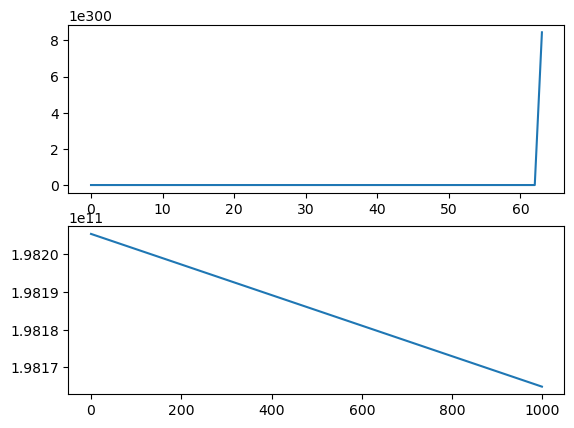

In [35]:
fig, ax = plt.subplots(2)
ax[0].plot(losses_large)
ax[1].plot(losses_small)

In [36]:
initial_w = initial_weights(n_features)
w_small_2, losses_small_2 = gradient_descent(xb, y, initial_w, 1001, small_lr)

pred_1 = predict(xb, w_small)
pred_2 = predict(xb, w_small_2)

mse(pred_1, y), mse(pred_2, y)

(198164761907.94873, 198164721213.6328)

using a large lr causes the model to diverge and not getting a good result<br>
also using a very small lr makes the model slow and the learning would take so long(we can see in the cell above that the loss on the next epoch is relatively close to the previous one. this means that the model is slow is minimiznig loss). so we should choose a proper value that is neither small or large

## Using Library

In [37]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()

In [38]:
tic = time.time()
model.fit(xb, y)
tok = time.time()

sk_time = tok - tic
print(f"library training time: {sk_time}s")

model.score(xb, y)

library training time: 0.002251148223876953s


0.9988077770854864

In [39]:
print("weights: ", model.coef_)

weights:  [157850.35742253   1082.80836969   1006.59708821   6852.2751544
   4392.93830981   1833.20266508  12412.66898057   7080.16092081
      0.        ]


In [40]:
sample = np.array([7700, 3, 2, 1, 1, 0, 0, 2])
sample_n = normalize(sample, [mean, std_dev])

# adding bias term:
sample_norm = np.hstack([sample_n, 1])

model.predict(np.array([sample_norm]))

array([790922.91902032])

In [41]:
y_sk = model.predict(xb)
y_batch = predict(xb, w_batch)

## Comparisons

In [42]:
mse_sk = mse(y_sk, y)
mse_batch = mse(y_batch, y)
print("mse for library: ", mse_sk)
print("mse for implemented batch: ", mse_batch)

mse for library:  16082448.516397253
mse for implemented batch:  18648853.26690521


In [43]:
print("Batch training time in seconds: ", batch_time)
print("Library training time in seconds:", sk_time)

Batch training time in seconds:  0.01468801498413086
Library training time in seconds: 0.002251148223876953


So we can see that the library is faster    

# Q2

## A)

In [44]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("./data/Data.csv")
x, y = data["X"], data["Y"]
xb = np.column_stack([np.ones_like(x), x])
print(xb.shape)

(50, 2)


In [45]:
data.head()

,X,Y
0,-0.994787,6.808710
1,-0.950996,6.460205
2,-0.919999,7.354000
3,-0.876221,7.420564
4,-0.838166,7.595328


## Split into train and test sets

In [46]:
train, test_set = train_test_split(data, random_state=10, test_size=0.2)

In [47]:
train.shape

(40, 2)

In [48]:
test_set.shape

(10, 2)

## B)

## split into train and val sets

In [49]:
train_set, val_set = train_test_split(train, random_state=10, test_size=0.2)

In [50]:
print(train_set.shape, val_set.shape)

(32, 2) (8, 2)


In [51]:
x_train, y_train = train_set["X"], train_set["Y"]
x_val, y_val = val_set["X"], val_set["Y"]
x_test, y_test = test_set["X"], test_set["Y"]

xb_train = np.column_stack([np.ones_like(x_train), x_train])
xb_val = np.column_stack([np.ones_like(x_val), x_val])
xb_test = np.column_stack([np.ones_like(x_test), x_test])

print(xb_val.shape, xb_train.shape)

(8, 2) (32, 2)


In [52]:
n_features = xb_train.shape[1]
print(n_features)

2


### Hypter parameter tunning using CV

In [53]:
n_epochs = 100
lr_opt = [10, 1, 0.1, 0.01, 0.001, 0.0001]

In [54]:
best_loss = np.inf 
best_w = []
best_lr = 0
best_time_gd = 0

for lr in lr_opt:
    initial_w = initial_weights(n_features)
    tic = time.time()
    w, losses = gradient_descent(xb_train, y_train, initial_w, n_epochs, lr)
    tok = time.time()
    
    val_pred = predict(xb_val, w)
    loss = mse(val_pred, y_val)
    
    if best_loss > loss:
        best_loss = loss
        best_w = w
        best_lr = lr
        best_time_gd = tok - tic
        
print(best_loss, best_w, best_lr)

0.9613194523901241 [ 8.41568155 -0.40481265] 0.1


### Plotting

In [55]:
pred = predict(xb, best_w)

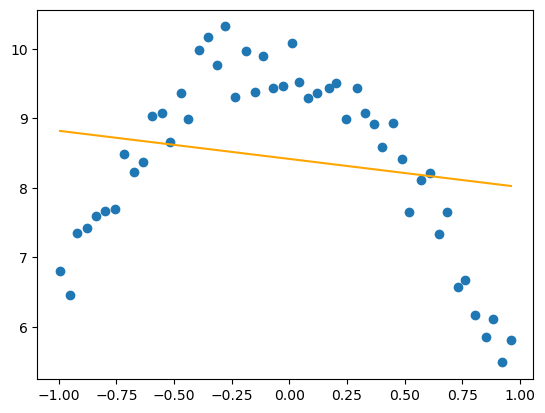

In [56]:
plt.scatter(x, y)
plt.plot(x, pred, color='orange')

### Loss on Train and Test

In [57]:
train_pred = predict(xb_train, best_w)
test_pred = predict(xb_test, best_w)
gd_train_loss = mse(train_pred, y_train)
gd_test_loss = mse(test_pred, y_test)

print(f"loss on train set: {gd_train_loss}\nloss on test set: {gd_test_loss}")

loss on train set: 0.7467593546474648
loss on test set: 0.6797011710433558


we can see that loss on train set is higher than loss on test set <br>
this is because the model is underfit and both of them have high losses. <br>
also the the data we are working on is simple and very little in the number.

## C)

### Close Form Sol

In [58]:
def close_form_sol(x, y):
    return np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)

In [59]:
tic = time.time()
w_cfs = close_form_sol(xb_train, y_train)
tok = time.time()
cfs_time = tok - tic

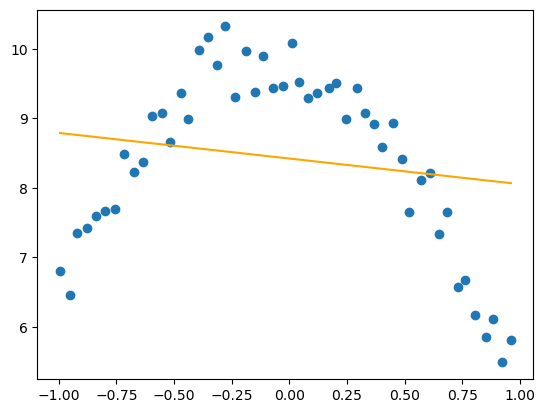

In [60]:
pred = predict(xb, w_cfs)
plt.scatter(x, y)
plt.plot(x, pred, color='orange')

### Loss on Train and Test

In [61]:
train_pred = predict(xb_train, w_cfs)
test_pred = predict(xb_test, w_cfs)

cfs_train_loss = mse(train_pred, y_train)
cfs_test_loss = mse(test_pred, y_test)

print(f"loss on train set: {cfs_train_loss}\nloss on test set: {cfs_test_loss}")

loss on train set: 0.7465436219668953
loss on test set: 0.6853751594616052


### time comparison:

In [62]:
print("time GD: ", best_time_gd)
print("time close form: ", cfs_time)

time GD:  0.017721891403198242
time close form:  0.0001201629638671875


because the number of features is small the close form solution is faster than gd.

### loss comparison gd and cfs:

In [63]:
print(f"train loss in gd: {gd_train_loss}")
print(f"train loss in cfs: {cfs_train_loss}")
print("-"*40)
print(f"test loss in gd: {gd_test_loss}")
print(f"test loss in cfs: {cfs_test_loss}")

train loss in gd: 0.7467593546474648
train loss in cfs: 0.7465436219668953
----------------------------------------
test loss in gd: 0.6797011710433558
test loss in cfs: 0.6853751594616052


the test loss in gd is smaller than cfs this is because the cfs finds the best possible weights and this leads to overfitting. also the loss on train is smaller for cfs that confirms this. but the model by gd is better in test.

## D)

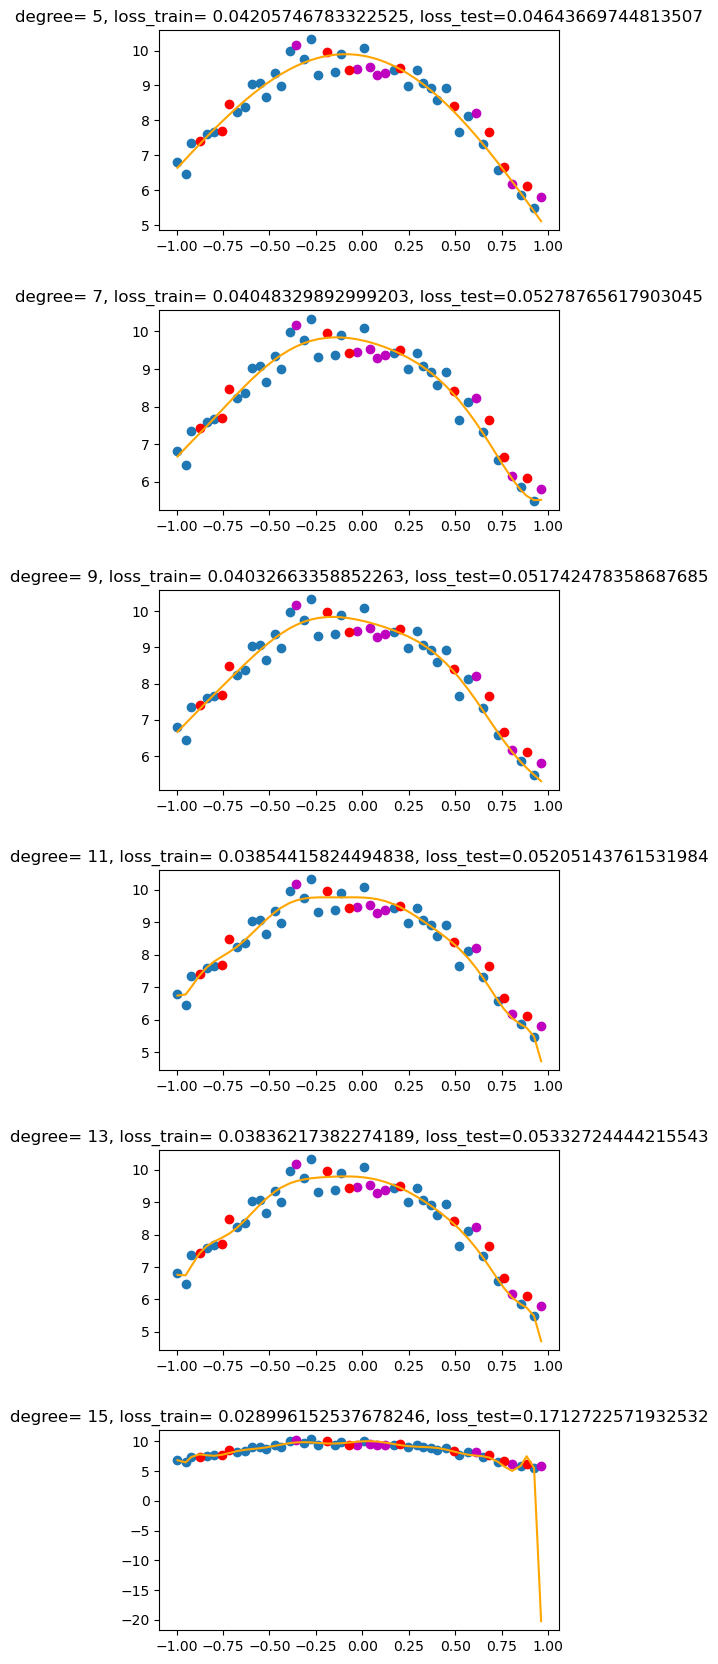

In [64]:
fig, axs = plt.subplots(6, figsize=(5, 20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

degrees = [5, 7, 9 , 11, 13, 15]
for i, degree in enumerate(degrees):
    stack_list = [xb_train]
    stack_list_test = [xb_test]
    stack_list_all = [xb]
    for k in range(2, degree + 1): 
        stack_list.append(x_train**k)
        stack_list_test.append(x_test**k)
        stack_list_all.append(x**k)
    x_complex = np.column_stack(stack_list)
    x_complex_test = np.column_stack(stack_list_test)
    x_complex_all = np.column_stack(stack_list_all)
        
    w_complex = close_form_sol(x_complex, y_train)
    pred = predict(x_complex, w_complex)
    pred_test = predict(x_complex_test, w_complex)
    pred_all = predict(x_complex_all, w_complex)
    
    loss_test = mse(pred_test, y_test)
    loss_train = mse(pred, y_train)
    
    
    axs[i].set_title(f"degree= {degree}, loss_train= {loss_train}, loss_test={loss_test}")
    axs[i].scatter(x_train, y_train)
    axs[i].scatter(x_val, y_val, color="m")
    axs[i].scatter(x_test, y_test, color="red")
    axs[i].plot(x, pred_all, color='orange')

we see that as the degrees increases, the loss on train set decreases and the loss on test set increases. this means that the model is having the overfitting problem.

## E)

### Ridge Close Form Sol

In [65]:
def ridge_cfs(x, y, alpha):
    n = x.shape[1]
    return np.linalg.inv(x.T.dot(x) + alpha * np.eye(n)).dot(x.T).dot(y)
    

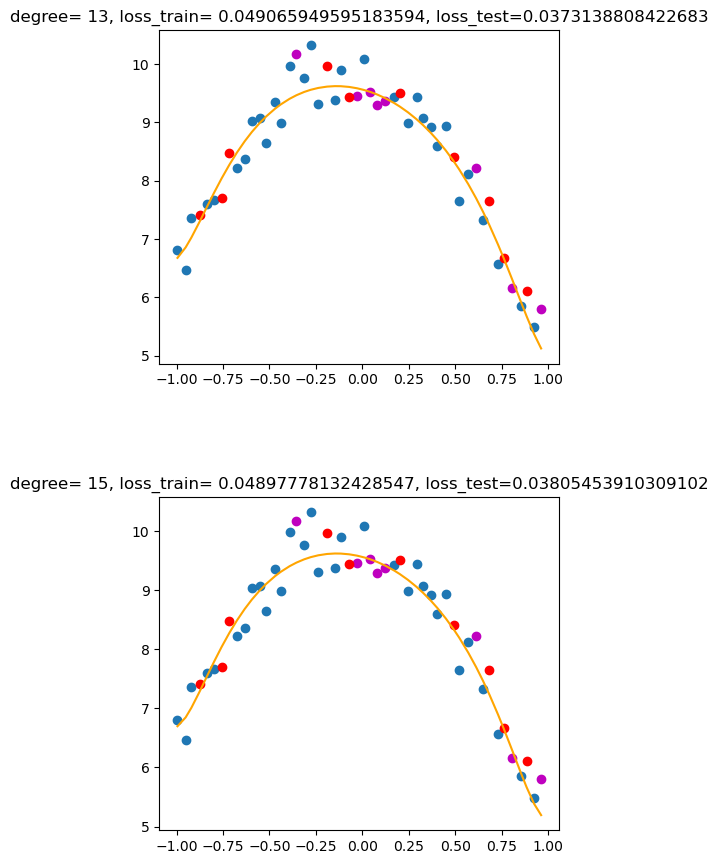

In [66]:
fig, axs = plt.subplots(2, figsize=(5, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

degrees = [13, 15]
for i, degree in enumerate(degrees):
    stack_list = [xb_train]
    stack_list_test = [xb_test]
    stack_list_all = [xb]
    for k in range(2, degree + 1): 
        stack_list.append(x_train**k)
        stack_list_test.append(x_test**k)
        stack_list_all.append(x**k)
    x_complex = np.column_stack(stack_list)
    x_complex_test = np.column_stack(stack_list_test)
    x_complex_all = np.column_stack(stack_list_all)
        
    w_complex = ridge_cfs(x_complex, y_train, 0.1)
    pred = predict(x_complex, w_complex)
    pred_test = predict(x_complex_test, w_complex)
    pred_all = predict(x_complex_all, w_complex)
    
    loss_test = mse(pred_test, y_test)
    loss_train = mse(pred, y_train)
    
    
    axs[i].set_title(f"degree= {degree}, loss_train= {loss_train}, loss_test={loss_test}")
    axs[i].scatter(x_train, y_train)
    axs[i].scatter(x_val, y_val, color="m")
    axs[i].scatter(x_test, y_test, color="red")
    axs[i].plot(x, pred_all, color='orange')

because of the regularizatoin term, despite the fact that we added more degrees, the model is not overfitted and the test and train losses are close and the model is just right.

## F)

### Lasso Regression

In [67]:
from sklearn.linear_model import Lasso


#### preping the data:

In [68]:


degrees = [13, 15]
for i, degree in enumerate(degrees):
    stack_list = [xb_train]
    stack_list_test = [xb_test]
    stack_list_all = [xb]
    for k in range(2, degree + 1): 
        stack_list.append(x_train**k)
        stack_list_test.append(x_test**k)
        stack_list_all.append(x**k)
    x_complex = np.column_stack(stack_list)
    x_complex_test = np.column_stack(stack_list_test)
    x_complex_all = np.column_stack(stack_list_all)
        
    # close form solution
    w_complex_cfs = close_form_sol(x_complex, y_train) 
    pred_cfs = predict(x_complex, w_complex_cfs)
    pred_test_cfs = predict(x_complex_test, w_complex_cfs)
    pred_all_cfs = predict(x_complex_all, w_complex_cfs)
    
    # ridge close form solution
    w_complex_ridge_cfs = ridge_cfs(x_complex, y_train, 0.1) 
    pred_ridge_cfs = predict(x_complex, w_complex_ridge_cfs)
    pred_test_ridge_cfs = predict(x_complex_test, w_complex_ridge_cfs)
    pred_all_ridge_cfs = predict(x_complex_all, w_complex_ridge_cfs)
    
    # library
    model = Lasso(alpha=0.1)
    model.fit(x_complex, y_train)
    pred_lib = model.predict(x_complex)
    pred_test_lib = model.predict(x_complex_test)
    pred_all_lib = model.predict(x_complex_all)
    

    loss_test = mse(pred_test, y_test)
    loss_train = mse(pred, y_train)
    
    # comparing the weights:
    print("degree: ", degree)
    print("lib weights: \n", model.coef_ )
    print("cfs weights: \n", w_complex_cfs )
    print("ridge cfs weights: \n", w_complex_ridge_cfs )
    print("-" * 40)
    

degree:  13
lib weights: 
 [ 0.         -0.41749373 -2.79099355 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.        ]
cfs weights: 
 [   9.77039038   -0.61356131   -4.25007031   -5.86928521   10.24180853
   23.21672684  -65.13623316   13.35615949  126.87854539 -189.03383248
  -91.01687988  290.89828979   18.17823365 -134.12903887]
ridge cfs weights: 
 [ 9.56472830e+00 -8.36396899e-01 -2.97936669e+00 -9.47005375e-02
 -1.45742579e+00 -2.25156392e-02 -3.61830478e-01  1.65494567e-02
  1.59437173e-01  3.71226682e-02  3.90335866e-01  3.34349613e-02
  4.89143703e-01  9.17057482e-03]
----------------------------------------
degree:  15
lib weights: 
 [ 0.         -0.41749373 -2.79099355 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.          0.        ]
cfs weights: 
 [ 9.99199240e+00  1.80019208e+00 -2.35856762e+01 -1.01172076e+02
  3.94002495e+02  1.2191

we can see that in ridge some weights are so close to zero but the correspoinding weight in lasso is exactly zero.
<br> and the weights in the model without regulatization is not zero and is overfitted

# Theory Problem 8

## sgd

In [69]:
# import numpy as np
# w = np.array([-59.5, -0.15, 0.6])
# lr = 0.1
# def predict(x, w):
#     return x.dot(w)
# print(-59.5 * 1 + 42 * -0.15 + 0.6 * 153)

In [70]:
# x = np.array([[41, 138], [42, 153], [37, 151], [46, 133]])
# y = np.array([37.99, 47.34, 44.38, 28.17])
# print(x.shape, y.shape)

In [71]:
# xs = np.hstack([np.ones((4, 1)), x])
# print(xs)

In [72]:
# prediction = predict(xs, w)
# print(prediction.shape, prediction)

In [73]:
# print(1/4 * np.sum(np.abs(prediction - y)))
# 17.15 - y[0]

In [74]:
# def gradient(x, y, pred):
#     e = pred - y
#     print(e)
#     return  2 * e * x

In [75]:
# dw = gradient(xs[0], y[0], prediction[0])

In [76]:
# print(dw)

In [77]:
# print("x: ", xs[0])
# print("iw: ", w)
# print("y: ", y[0])
# print("y_pred: ", prediction[0])

In [78]:
# w1 = w - lr * dw
# print(lr * dw)


# print("dw0: ", dw)
# print("w1: ", w1)

In [79]:
# prediction = predict(xs, w1)
# dw1 = gradient(xs[1], y[1], prediction[1])
# w2 = w1 - lr * dw1
# print(prediction)
# print("-lr * dw1: ", -lr * dw1)
# print("dw1: ", dw1)
# print("w2: ", w2)

In [80]:
# prediction = predict(xs, w2)
# dw2 = gradient(xs[2], y[2], prediction[2])
# w3 = w2 - lr * dw2
# print(prediction)
# print("dw2: ", dw2)
# print("w3: ", w3)

In [81]:
# prediction = predict(xs, w3)
# dw3 = gradient(xs[3], y[3], prediction[3])
# w4 = w3 - lr * dw3

# print(prediction)
# print("dw3: ", dw3)
# print("w4: ", w4)

In [82]:
# pred_sgd = predict(xs, w4)
# print(pred_sgd)

In [83]:
# mse(pred_sgd, y)

## GD

In [84]:
# def gd_gradient(x, y, pred):
#     m = len(y)
#     e = pred - y
#     return  (1/m) *  x.T.dot(e)

In [85]:
# prediction = predict(xs, w)
# dw = gd_gradient(xs, y, prediction)
# print(dw)

In [86]:
# w1_dg = w - lr * dw

In [87]:
# w1_dg

In [88]:
# pred = predict(xs, w1_dg)

In [89]:
# mse(pred, y)